<a href="https://colab.research.google.com/github/yashv04/Impact-Model-IPL-Auction-Strategy/blob/main/Impact_Index_Model_%2B_IPL_Auction_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('ball by ball 2024.csv')

df.head(1)

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN


In [ ]:
df.extras_type.unique()

array(['legbyes', nan, 'wides', 'byes', 'noballs', 'penalty'],
      dtype=object)

# **Player Impact Score Model using the following contextual metrics:**

In [ ]:
#Batsmen
# Step 1: Add match phase (Powerplay, Middle, Death)
def get_match_phase(over):
    if 1 <= over + 1 <= 6:
        return 'Powerplay'
    elif 7 <= over + 1 <= 15:
        return 'Middle'
    elif 16 <= over + 1 <= 20:
        return 'Death'
    else:
        return 'Other'

df['match_phase'] = df['over'].apply(get_match_phase)

# Step 2: Game state - Chasing or Defending
df['game_state'] = df['inning'].apply(lambda x: 'Defending' if x == 1 else 'Chasing')

# Step 3: Basic batting stats
batting_stats = df.groupby('batter').agg(
    matches_played=('match_id', 'nunique'),
    total_runs=('batsman_runs', 'sum'),
    total_balls=('ball', 'count'),
    total_4s=('batsman_runs', lambda x: (x == 4).sum()),
    total_6s=('batsman_runs', lambda x: (x == 6).sum()),
).reset_index()

batting_stats['strike_rate'] = batting_stats['total_runs'] / batting_stats['total_balls'] * 100
average_sr = batting_stats['strike_rate'].mean()
batting_stats['SR_vs_avg_SR'] = batting_stats['strike_rate'] / average_sr

# Step 4: Contextual phase runs
phase_runs = df.groupby(['batter', 'match_phase'])['batsman_runs'].sum().unstack(fill_value=0).reset_index()
batting_stats = batting_stats.merge(phase_runs, on='batter', how='left')

# Step 5: Result influence approximation - count 30+ innings
impact_contributions = df.groupby(['match_id', 'batter'])['batsman_runs'].sum().reset_index()
impact_contributions['impact_performance'] = impact_contributions['batsman_runs'] >= 30
result_influence = impact_contributions.groupby('batter')['impact_performance'].sum().reset_index()
result_influence.rename(columns={'impact_performance': 'impact_performances'}, inplace=True)
batting_stats = batting_stats.merge(result_influence, on='batter', how='left')
batting_stats['impact_performances'] = batting_stats['impact_performances'].fillna(0)

# Step 6: Normalize and calculate impact score
features_to_scale = ['total_runs', 'SR_vs_avg_SR', 'Powerplay', 'Middle', 'Death', 'impact_performances']
scaler = MinMaxScaler()
batting_stats_scaled = batting_stats.copy()
batting_stats_scaled[features_to_scale] = scaler.fit_transform(batting_stats_scaled[features_to_scale])

batting_stats_scaled['impact_score'] = (
    0.25 * batting_stats_scaled['total_runs'] +
    0.15 * batting_stats_scaled['SR_vs_avg_SR'] +
    0.15 * batting_stats_scaled['Powerplay'] +
    0.15 * batting_stats_scaled['Middle'] +
    0.05 * batting_stats_scaled['Death'] +
    0.25 * batting_stats_scaled['impact_performances']
)

# Leaderboard
batting_leaderboard = batting_stats_scaled[['batter', 'impact_score']].sort_values(
    by='impact_score', ascending=False).reset_index(drop=True)

# Output top 10
print(batting_leaderboard.head(10))

           batter  impact_score
0         V Kohli      0.859950
1        S Dhawan      0.747399
2       DA Warner      0.741781
3       RG Sharma      0.711624
4        SK Raina      0.612074
5      RV Uthappa      0.566577
6        CH Gayle      0.556930
7  AB de Villiers      0.543577
8    F du Plessis      0.530062
9       AM Rahane      0.528696


In [ ]:
#Bowlers
# Step 1: Add match phase

def get_match_phase(over):
    if 1 <= over + 1 <= 6:
        return 'Powerplay'
    elif 7 <= over + 1 <= 15:
        return 'Middle'
    elif 16 <= over + 1 <= 20:
        return 'Death'
    else:
        return 'Other'

df['match_phase'] = df['over'].apply(get_match_phase)

# Step 2: Filter only legal deliveries (no wides/no-balls for economy)
df['legal_delivery'] = (df['extras_type'].isna())
legal_df = df[df['legal_delivery']]

# Step 3: Identify wickets (excluding runouts, etc.)
valid_wickets = [
    "bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"
]
df['is_wicket'] = df['dismissal_kind'].isin(valid_wickets)

# Step 4: Basic bowling stats
bowling_stats = legal_df.groupby('bowler').agg(
    total_runs_conceded=('batsman_runs', 'sum'),
    total_balls=('ball', 'count'),
).reset_index()

# Add wickets from the original df
wickets = df[df['is_wicket']].groupby('bowler')['is_wicket'].sum().reset_index()
bowling_stats = bowling_stats.merge(wickets, on='bowler', how='left')
bowling_stats.rename(columns={'is_wicket': 'wickets'}, inplace=True)
bowling_stats['wickets'] = bowling_stats['wickets'].fillna(0)

# Calculate economy rate
bowling_stats['economy'] = bowling_stats['total_runs_conceded'] / (bowling_stats['total_balls'] / 6)

# Compare to average economy
average_economy = bowling_stats['economy'].mean()
bowling_stats['Eco_vs_avg_Eco'] = average_economy / bowling_stats['economy'].replace(0, 1e-6)  # higher is better

# Step 5: Contextual overs (phase deliveries)
phase_deliveries = df.groupby(['bowler', 'match_phase'])['ball'].count().unstack(fill_value=0).reset_index()
bowling_stats = bowling_stats.merge(phase_deliveries, on='bowler', how='left')

# Step 6: Impact performances (2+ wickets in a match)
match_wickets = df[df['is_wicket']].groupby(['match_id', 'bowler'])['is_wicket'].count().reset_index()
match_wickets['impact_performance'] = match_wickets['is_wicket'] >= 2
impact_perf = match_wickets.groupby('bowler')['impact_performance'].sum().reset_index()
bowling_stats = bowling_stats.merge(impact_perf, on='bowler', how='left')
bowling_stats['impact_performance'] = bowling_stats['impact_performance'].fillna(0)

# Step 7: Normalize and calculate impact score
features_to_scale = ['wickets', 'Eco_vs_avg_Eco', 'Powerplay', 'Middle', 'Death', 'impact_performance']
scaler = MinMaxScaler()
bowling_scaled = bowling_stats.copy()
bowling_scaled[features_to_scale] = scaler.fit_transform(bowling_scaled[features_to_scale])

bowling_scaled['impact_score'] = (
    0.3 * bowling_scaled['wickets'] +
    0.2 * bowling_scaled['Eco_vs_avg_Eco'] +
    0.15 * bowling_scaled['Powerplay'] +
    0.15 * bowling_scaled['Middle'] +
    0.05 * bowling_scaled['Death'] +
    0.15 * bowling_scaled['impact_performance']
)

# Sort and show leaderboard
bowling_leaderboard = bowling_scaled[['bowler', 'impact_score']].sort_values(
    by='impact_score', ascending=False).reset_index(drop=True)

# Output top 10 bowlers
print(bowling_leaderboard.head(10))

       bowler  impact_score
0    R Ashwin      0.620238
1   YS Chahal      0.619174
2     B Kumar      0.611696
3   PP Chawla      0.594668
4   SP Narine      0.581513
5    DJ Bravo      0.552823
6  SL Malinga      0.533842
7   JJ Bumrah      0.532462
8    A Mishra      0.532054
9   RA Jadeja      0.516701


 Rohit Sharma Contextual Breakdown

In [ ]:
# Filter Rohit Sharma's deliveries
rohit_df = df[df['batter'] == 'RG Sharma']

# Basic stats
total_runs = rohit_df['batsman_runs'].sum()
total_balls = rohit_df['ball'].count()
strike_rate = (total_runs / total_balls) * 100
average_sr = df.groupby('batter')['batsman_runs'].sum().sum() / df['ball'].count() * 100
SR_vs_avg = strike_rate / average_sr

# Runs by phase
phase_runs = rohit_df.groupby('match_phase')['batsman_runs'].sum().to_dict()
powerplay_runs = phase_runs.get('Powerplay', 0)
middle_runs = phase_runs.get('Middle', 0)
death_runs = phase_runs.get('Death', 0)

# Impact performances (30+ scores)
impact_performances = rohit_df.groupby('match_id')['batsman_runs'].sum()
impact_count = (impact_performances >= 30).sum()

# Print breakdown
print(f" Breakdown: RG Sharma")
print(f"• Total Runs: {total_runs}")
print(f"• Balls Faced: {total_balls}")
print(f"• Strike Rate: {strike_rate:.2f}")
print(f"• SR vs Avg SR: {SR_vs_avg:.2f}")
print(f"• Runs in Powerplay: {powerplay_runs}")
print(f"• Runs in Middle Overs: {middle_runs}")
print(f"• Runs in Death Overs: {death_runs}")
print(f"• 30+ Impact Innings: {impact_count}")

 Breakdown: RG Sharma
• Total Runs: 6630
• Balls Faced: 5183
• Strike Rate: 127.92
• SR vs Avg SR: 1.01
• Runs in Powerplay: 2137
• Runs in Middle Overs: 2980
• Runs in Death Overs: 1513
• 30+ Impact Innings: 94


Bumrah’s Impact Breakdown (Contextual Model)

In [ ]:
# Filter Jasprit Bumrah's data
bumrah_df = df[df['bowler'] == 'JJ Bumrah']
legal_bumrah_df = bumrah_df[bumrah_df['extras_type'].isna()]

# Total runs conceded and legal deliveries
total_runs = legal_bumrah_df['batsman_runs'].sum()
total_balls = legal_bumrah_df['ball'].count()
economy = total_runs / (total_balls / 6)

# Average economy across all bowlers
all_legal = df[df['extras_type'].isna()]
avg_economy = all_legal['batsman_runs'].sum() / (all_legal['ball'].count() / 6)
eco_vs_avg = avg_economy / economy  # higher is better

# Wickets taken
valid_wickets = [
    "bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"
]
wickets = bumrah_df[bumrah_df['dismissal_kind'].isin(valid_wickets)].shape[0]

# Overs bowled in each phase
phase_overs = bumrah_df.groupby('match_phase')['ball'].count() / 6
powerplay_overs = phase_overs.get('Powerplay', 0)
middle_overs = phase_overs.get('Middle', 0)
death_overs = phase_overs.get('Death', 0)

# Impact performances (2+ wickets in a match)
match_wickets = bumrah_df[bumrah_df['dismissal_kind'].isin(valid_wickets)]\
    .groupby('match_id')['dismissal_kind'].count()
impact_matches = (match_wickets >= 2).sum()

# Output the breakdown
print(f"Breakdown: Jasprit Bumrah")
print(f"• Total Wickets: {wickets}")
print(f"• Economy Rate: {economy:.2f}")
print(f"• Economy vs Avg: {eco_vs_avg:.2f}")
print(f"• Overs in Powerplay: {powerplay_overs:.2f}")
print(f"• Overs in Middle Overs: {middle_overs:.2f}")
print(f"• Overs in Death Overs: {death_overs:.2f}")
print(f"• Impact Matches (2+ wickets): {impact_matches}")

Breakdown: Jasprit Bumrah
• Total Wickets: 168
• Economy Rate: 7.14
• Economy vs Avg: 1.12
• Overs in Powerplay: 182.33
• Overs in Middle Overs: 132.17
• Overs in Death Overs: 216.33
• Impact Matches (2+ wickets): 50


Player_impact_visualization

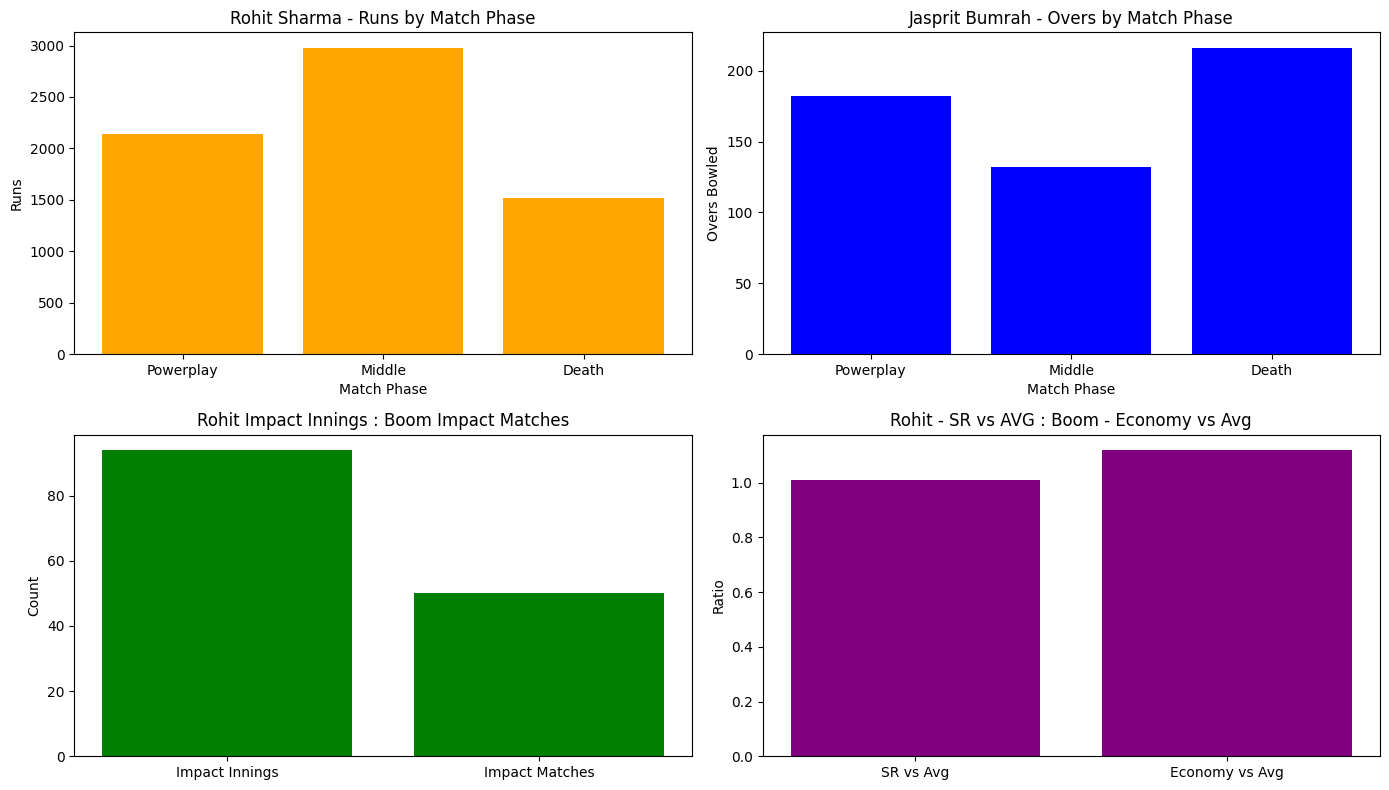

In [ ]:
# Cell 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Cell 2: Player Data (replace with real values after analysis)
rohit_data = {
    'Player': 'Rohit Sharma',
    'Powerplay': 2137,
    'Middle': 2980,
    'Death': 1513,
    'Impact Innings': 94,
    'Strike Rate vs Avg': 1.01
}

bumrah_data = {
    'Player': 'Jasprit Bumrah',
    'Powerplay': 182.33,
    'Middle': 132.17,
    'Death': 216.33,
    'Impact Matches': 50,
    'Economy vs Avg': 1.12
}

# Cell 3: Create phase data
rohit_df = pd.DataFrame({
    'Phase': ['Powerplay', 'Middle', 'Death'],
    'Runs Scored': [rohit_data['Powerplay'], rohit_data['Middle'], rohit_data['Death']]
})

bumrah_df = pd.DataFrame({
    'Phase': ['Powerplay', 'Middle', 'Death'],
    'Overs Bowled': [bumrah_data['Powerplay'], bumrah_data['Middle'], bumrah_data['Death']]
})

# Cell 4: Plot bar charts
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8))

# Rohit Sharma - Batting Phases
ax1.bar(rohit_df['Phase'], rohit_df['Runs Scored'], color='orange')
ax1.set_title("Rohit Sharma - Runs by Match Phase")
ax1.set_ylabel("Runs")
ax1.set_xlabel("Match Phase")

ax3.bar('Impact Innings', rohit_data['Impact Innings'], color='green')
ax3.set_title("Rohit Sharma - Impact Innings (30+ Runs)")
ax3.set_ylabel("Count")

ax4.bar('SR vs Avg', rohit_data['Strike Rate vs Avg'], color='purple')
ax4.set_title("Rohit Sharma - Strike Rate vs Avg")
ax4.set_ylabel("Ratio")


# Jasprit Bumrah - Bowling Phases
ax2.bar(bumrah_df['Phase'], bumrah_df['Overs Bowled'], color='blue')
ax2.set_title("Jasprit Bumrah - Overs by Match Phase")
ax2.set_ylabel("Overs Bowled")
ax2.set_xlabel("Match Phase")

ax3.bar('Impact Matches', bumrah_data['Impact Matches'], color='green')
ax3.set_title("Rohit Impact Innings : Boom Impact Matches")
ax3.set_ylabel("Count")

ax4.bar('Economy vs Avg', bumrah_data['Economy vs Avg'], color='purple')
ax4.set_title("Rohit - SR vs AVG : Boom - Economy vs Avg")
ax4.set_ylabel("Ratio")

plt.tight_layout()
plt.show()

# **Auction Squad Optimizer Model**

In [ ]:
!pip install pulp

In [ ]:
from pulp import *

auction_df = pd.read_csv('IPLPlayerAuctionData.csv')
ball_by_ball_df = pd.read_csv('ball by ball 2024.csv')

In [ ]:
# Batting stats
batting_stats = (
    ball_by_ball_df.groupby('batter')
    .agg(total_runs=('batsman_runs', 'sum'),
         balls_faced=('batsman_runs', 'count'),
         innings=('match_id', 'nunique'),
         dismissals=('is_wicket', 'sum'))
    .reset_index()
    .rename(columns={'batter': 'Player'})
)

# Bowling stats
bowling_stats = (
    ball_by_ball_df.groupby('bowler')
    .agg(balls_bowled=('ball', 'count'),
         runs_conceded=('total_runs', 'sum'),
         wickets_taken=('is_wicket', 'sum'),
         matches_bowled=('match_id', 'nunique'))
    .reset_index()
    .rename(columns={'bowler': 'Player'})
)

# Merge batting and bowling
performance_stats = pd.merge(batting_stats, bowling_stats, on='Player', how='outer').fillna(0)

auction_df_unique = auction_df.drop_duplicates(subset='Player')

# Merge with auction data
merged_df = pd.merge(auction_df_unique, performance_stats, on='Player', how='left').fillna(0)

# Calculate scores
merged_df['batting_score'] = (merged_df['total_runs'] / merged_df['balls_faced'].replace(0, 1)) * 100
merged_df['bowling_score'] = (merged_df['wickets_taken'] / merged_df['matches_bowled'].replace(0, 1)) * 25
merged_df['performance_score'] = 0.6 * merged_df['batting_score'] + 0.4 * merged_df['bowling_score']
eligible_players = merged_df[merged_df['Amount'] > 0].copy()

In [ ]:
print("Players available with auction data:", len(eligible_players))

print("\n Role distribution:")
print(eligible_players['Role'].value_counts())

print("\n Player Origin distribution:")
print(eligible_players['Player Origin'].value_counts())

print("\n Budget stats:")
print("Minimum player price:", eligible_players['Amount'].min())
print("Maximum player price:", eligible_players['Amount'].max())
print("Total pool value:", eligible_players['Amount'].sum())

Players available with auction data: 543

 Role distribution:
Role
All-Rounder      199
Bowler           192
Batsman          101
Wicket Keeper     51
Name: count, dtype: int64

 Player Origin distribution:
Player Origin
Indian      346
Overseas    197
Name: count, dtype: int64

 Budget stats:
Minimum player price: 1000000
Maximum player price: 150000000
Total pool value: 8309375000


In [ ]:
# Only enforce budget and squad size
model = LpProblem("IPL_Auction_Strategy_Test", LpMaximize)

player_vars = {
    player: LpVariable(f"select_{i}", cat='Binary')
    for i, player in enumerate(eligible_players['Player'])
}

model += lpSum(
    player_vars[p] * eligible_players.loc[eligible_players['Player'] == p, 'performance_score'].values[0]
    for p in eligible_players['Player']
)

model += lpSum(player_vars[p] for p in eligible_players['Player']
              if eligible_players.loc[eligible_players['Player'] == p, 'Player Origin'].values[0] != 'Indian') >= 4

model += lpSum(player_vars[p] for p in eligible_players['Player'] if eligible_players.loc[eligible_players['Player'] == p, 'Role'].values[0] == 'Batsman') >= 5
model += lpSum(player_vars[p] for p in eligible_players['Player'] if eligible_players.loc[eligible_players['Player'] == p, 'Role'].values[0] == 'Bowler') >= 5
model += lpSum(player_vars[p] for p in eligible_players['Player'] if eligible_players.loc[eligible_players['Player'] == p, 'Role'].values[0] == 'All-Rounder') >= 3
model += lpSum(player_vars[p] for p in eligible_players['Player'] if eligible_players.loc[eligible_players['Player'] == p, 'Role'].values[0] == 'Wicket Keeper') >= 2


model += lpSum(player_vars[p] for p in eligible_players['Player']) == 15

model += lpSum(
    player_vars[p] * eligible_players.loc[eligible_players['Player'] == p, 'Amount'].values[0]
    for p in eligible_players['Player']
) <= 950000000


model.solve()

1

In [ ]:
selected_players = [p for p in eligible_players['Player'] if player_vars[p].value() == 1]
selected_team = eligible_players[eligible_players['Player'].isin(selected_players)]
selected_team[['Player', 'Role', 'Player Origin', 'Amount', 'performance_score']]

,Player,Role,Player Origin,Amount,performance_score
17,Akash Deep,Bowler,Indian,2000000,105.000000
45,Anmolpreet Singh,Batsman,Indian,8000000,71.282051
67,Avesh Khan,Bowler,Indian,7000000,111.464516
139,Dhruv Jurel,Wicket Keeper,Indian,2000000,87.848101
169,Harbhajan Singh,Bowler,Indian,20000000,88.647406
179,Imran Tahir,Bowler,Overseas,10000000,68.089785
182,Ishan Kishan,Wicket Keeper,Indian,3500000,79.678553
210,Joe Denly,Batsman,Overseas,10000000,0.000000
243,KL Rahul,Batsman,Indian,10000000,78.630520
306,Mohammad Nabi,All-Rounder,Overseas,3000000,90.980338


Role Distribution (Pie Chart)

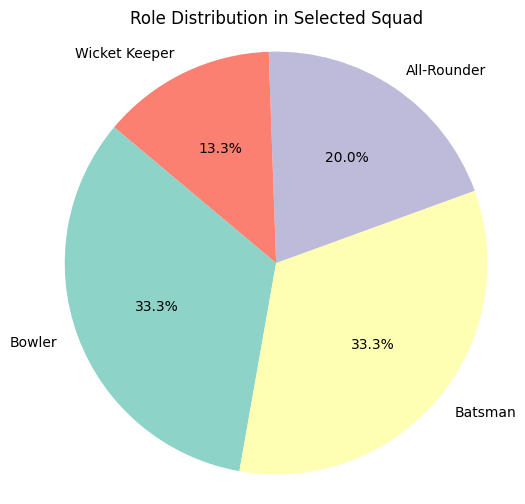

In [ ]:
import matplotlib.pyplot as plt

role_counts = selected_team['Role'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(role_counts, labels=role_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title('Role Distribution in Selected Squad')
plt.axis('equal')
plt.show()

Indian vs Overseas Players (Bar Plot)

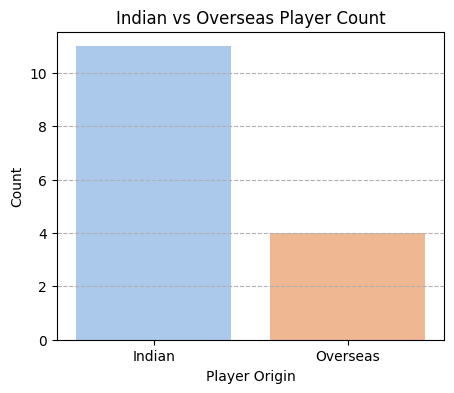

In [ ]:
import seaborn as sns

origin_counts = selected_team['Player Origin'].value_counts()

plt.figure(figsize=(5, 4))
sns.barplot(x=origin_counts.index, y=origin_counts.values, palette='pastel')
plt.title('Indian vs Overseas Player Count')
plt.xlabel('Player Origin')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--')
plt.show()

Player Cost vs Performance (Bar Plot)

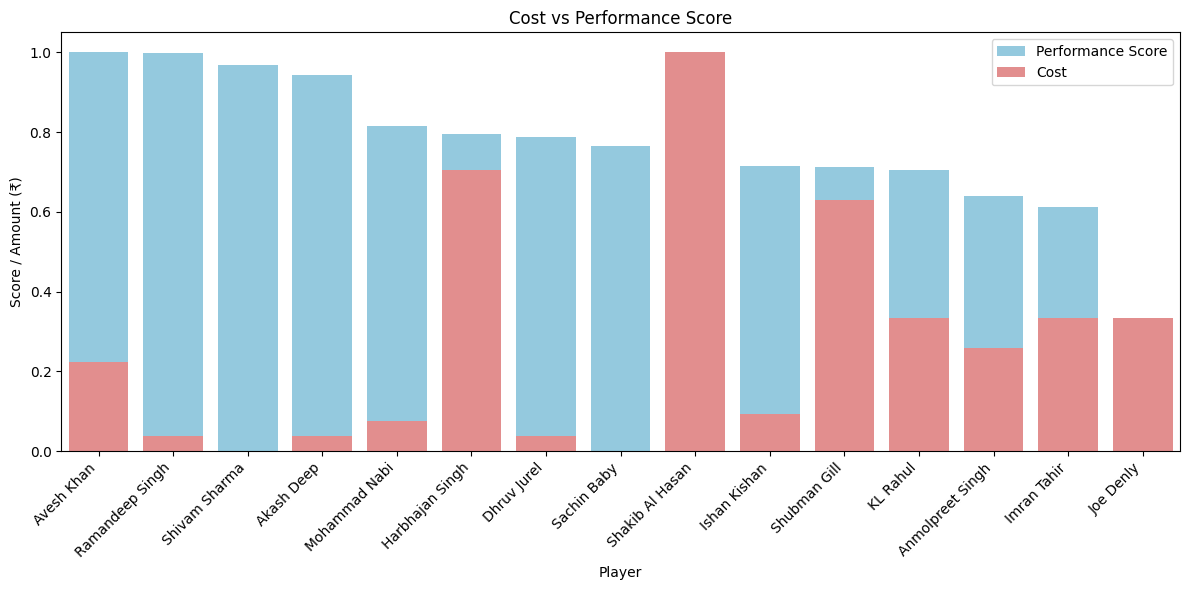

In [ ]:
# Sort by performance for better visuals
scaler = MinMaxScaler()
team_sorted[['performance_score', 'Amount']] = scaler.fit_transform(team_sorted[['performance_score', 'Amount']])

plt.figure(figsize=(12, 6))
sns.barplot(x='Player', y='performance_score', data=team_sorted, label='Performance Score', color='skyblue')
sns.barplot(x='Player', y='Amount', data= team_sorted, label='Cost', color='lightcoral')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Score / Amount (₹)')
plt.title('Cost vs Performance Score')
plt.legend()
plt.tight_layout()
plt.show()

Heatmap of Roles vs Origin

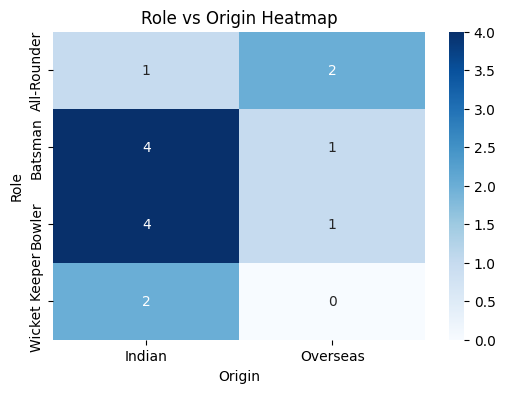

In [ ]:
role_origin_crosstab = pd.crosstab(selected_team['Role'], selected_team['Player Origin'])

plt.figure(figsize=(6, 4))
sns.heatmap(role_origin_crosstab, annot=True, cmap='Blues', fmt='d')
plt.title('Role vs Origin Heatmap')
plt.ylabel('Role')
plt.xlabel('Origin')
plt.show()

In cricket, traditional metrics like runs scored or wickets taken don’t always reflect a player’s true match impact. For example, a bowler who takes 1 wicket in a match but stops a key partnership could have a larger impact than a player who takes multiple wickets. This project solves the problem of quantifying player impact in a more holistic and meaningful way to help teams, analysts, and fantasy players identify the game-changers.

To calculate match impact, we used a combination of key performance metrics and weighted them based on their contribution to a game. The model combines:

Batting Metrics: Runs scored, boundary percentage, and partnerships formed.

Bowling Metrics: Wickets taken, economy rate, and pressure created.

Fielding Metrics: Catches, direct hits, and saving boundaries.

Context: We also factor in match situations like run chases, match pressure, and clutch moments (e.g., death overs performance).

We used Python (Pandas + NumPy) for data processing and calculations, with Tableau for visualizing the impact of key players in different match situations.

The model identified players who had a higher-than-expected impact on games, even if their traditional stats were average. For example, a bowler like Ravindra Jadeja (who may not always take 3-4 wickets) had a higher impact score due to his ability to create pressure in key moments and save runs in the field.

Key insights include:

Impact players in low-scoring games: Players who consistently contribute in tight matches are ranked higher.

Players excelling under pressure: For instance, players who perform better in chases or death overs were ranked as crucial match-winners.

Fantasy insights: By focusing on players with a high impact score, fantasy managers can make better selections.

Applications:

Team analysts can use the Impact Index to identify key players for specific match situations.

It can guide fantasy team selection, especially for high-stakes matches where match-winning contributions matter more than traditional stats.

Teams can optimize player performance by understanding which aspects of their game (batting, bowling, or fielding) contribute most to the team’s overall success.


